# Ranking car preferences 
***
This is an initial attempt to explore concepts of preference learning. We attempt to create a prediction model that takes user attributes and a pairwise ranking between two cars as inputs, and outputs whether the user prefers the first or the second car. 

In [1]:
#importing libraries
import pandas as pd #df
import numpy as np #arrays and matrices
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

#viz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style="white",
        palette="pastel",
        context="notebook")


#other
import urllib.request #download files
import zipfile #unzip
import os 

np.random.seed(42) #random seed for reproducibility

# Getting the data
We use the readily available car preference [dataset](http://users.cecs.anu.edu.au/~u4940058/CarPreferences.html), with the following description from the authors:
***
*We set up an experiment in Amazon Mechanical Turk to collect real pair-wise preferences over users. In this experiment users are presented with a choice to prefer a car over another based on their attributes. We have run two experiments with 10 and 20 cars respectively.*

*The preference questionnaire contains control questions that were randomly selected from the preferences with reversed order. These control questions were included to measure the consistency of the answers provided. In the dataset, we include all the information collected from the experiments. The reader may choose to exclude information based on the control questions which are indicators for random responses from that user.*
***

In [ ]:
# download zip file, unzip and delete zipfile
# skip if already done once, TO DO: automate skip if files exist
url = "http://users.cecs.anu.edu.au/~u4940058/data/exp1-prefs.zip"
filename = "cars_data/data.zip"
path= "cars_data"
urllib.request.urlretrieve(url, filename)
z = zipfile.ZipFile(filename,'r')
z.extractall(path)
z.close()
os.remove(filename)
os.listdir()

# Data description 
User attributes:
* Education:No response (0), High school (1), Bachelors (2), PhD (3)
* Age: No response (0), Below 25 (1), Between 25-30 (2), Between 30-35 (3), Above 40 (4)
* Gender: No response (0), Male (1), Female (2)
* Region: No response (0), South (1), West (2), North East (3), Mid West (4)

Car attributes
* Body type: Sedan (1), SUV (2)
* Transmission: Manual (1), Automatic (2)
* Engine capacity: 2.5L, 3.5L, 4.5L, 5.5L, 6.2L
* Fuel consumed: Hybrid (1), Non-Hybrid (2)

# Data exploration
As mentioned above, the dataset contains numbers for each category. For visualization purposes we will revert back to the category names for easier interpretation. We will then apply our own transformation to numerical values.

## Car attributes
The items dataset contains 10 types of cars with unique attributes that describe them, such as body type or type of transmission.  
Some insights from data description and visualization:
* There is an equal amount of SUVs and Sedans.
* Six out of ten vehicles are Automatic transmission.
* Six out of ten vehicles are Non-hybrid.
* There are no Hybrid cars with manual transmission.
* Hybrids have for the most part smaller engines than non-hybrid cars.
    * There is one exception, one hybrid car with engine capacity of 5.5L
* Manual transmission cars have a wider range of engine capacity.

In [7]:
#load in data and explore
items = pd.read_csv("cars_data/items1.csv")

#replacing numerical values with text category names according to description
items[" BodyType"] = items[" BodyType"].replace(1,"Sedan")
items[" BodyType"] = items[" BodyType"].replace(2,"SUV")

items[" Transmission"] = items[" Transmission"].replace(1,"Manual")
items[" Transmission"] = items[" Transmission"].replace(2,"Automatic")

items[" Fuel Consumed"] = items[" Fuel Consumed"].replace(1,"Hybrid")
items[" Fuel Consumed"] = items[" Fuel Consumed"].replace(2,"Non-Hybrid")

In [9]:
items.head()

,Item ID,BodyType,Transmission,Engin Capacity,Fuel Consumed
0,1,SUV,Manual,2.5,Non-Hybrid
1,2,Sedan,Automatic,5.5,Hybrid
2,3,Sedan,Manual,4.5,Non-Hybrid
3,4,Sedan,Manual,6.2,Non-Hybrid
4,5,SUV,Manual,3.5,Non-Hybrid


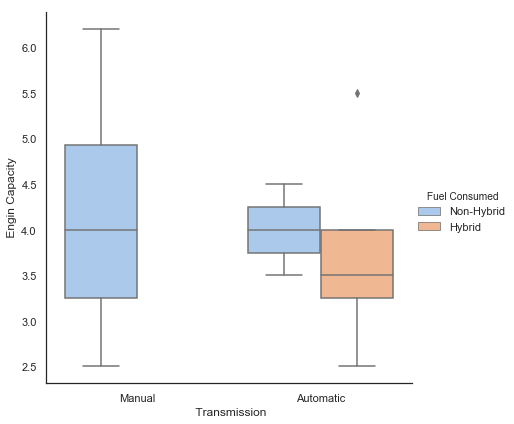

In [3]:
#plot categorical values
sns.catplot(
    y=" Engin Capacity",
    x=" Transmission",
    hue=" Fuel Consumed",
    kind="box",
    data=items,
    #kind="box",
    height=6,
    aspect=1
           )

In [10]:
items.describe(include='object')

,BodyType,Transmission,Fuel Consumed
count,10,10,10
unique,2,2,2
top,Sedan,Automatic,Non-Hybrid
freq,5,6,6


In [11]:
items.describe(exclude='object')

,Item ID,Engin Capacity
count,10.00000,10.000000
mean,5.50000,3.970000
std,3.02765,1.205589
min,1.00000,2.500000
25%,3.25000,3.500000
50%,5.50000,3.500000
75%,7.75000,4.500000
max,10.00000,6.200000


## User attributes
The users dataset contains 58 unique responders (after droping two respondents with missing values) with information on their education level, age, gender and region:
* The education level amongst respondents is hight, with 38 of them reporting having a PhD.
* 30 out of the 58 respondents are female.
* The most represented region is Southern U.S. with 18 respondents.
* There are no female respondents with high-school education, but instead have a  bachelor's or a PhD degree. 

In [12]:
users = pd.read_csv('cars_data/users1.csv')
# we will replace 0 values (no response) to NaN and drop them 
users = users.replace(0,np.nan)
users = users.dropna()

#replacing numerical values with text category names
users[" Education"] = users[" Education"].replace(1,"High School")
users[" Education"] = users[" Education"].replace(2,"Bachelors")
users[" Education"] = users[" Education"].replace(3,"PhD")

users[" Gender"] = users[" Gender"].replace(1,"Male")
users[" Gender"] = users[" Gender"].replace(2,"Female")

users[" Region"] = users[" Region"].replace(1,"South")
users[" Region"] = users[" Region"].replace(2,"West")
users[" Region"] = users[" Region"].replace(3,"North East")
users[" Region"] = users[" Region"].replace(4,"Mid West")

users.head()

,User ID,Education,Age,Gender,Region,# Correct Controls
0,1,PhD,4,Female,South,4
1,2,PhD,1,Female,Mid West,4
2,3,PhD,4,Female,Mid West,4
3,4,High School,4,Male,North East,5
4,5,Bachelors,3,Female,West,2


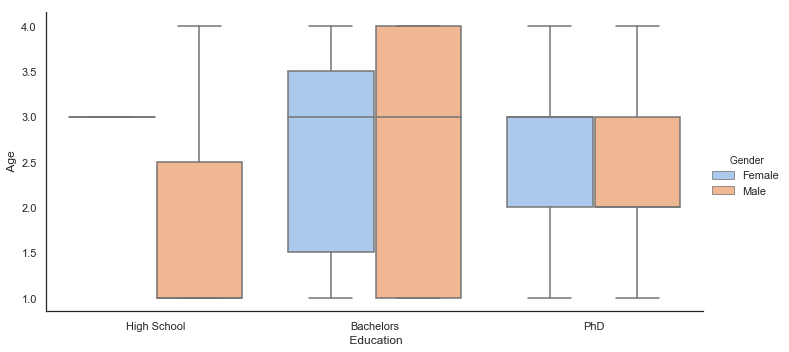

In [16]:
sns.catplot(
    x=" Education",
    y=" Age",
    order=["High School","Bachelors","PhD"],
    hue=" Gender",
    data=users,
    kind="box",
    height=5,
    aspect=2
           )

In [14]:
users.describe(include='object')

,Education,Gender,Region
count,58,58,58
unique,3,2,4
top,PhD,Female,South
freq,35,30,18


In [15]:
users.describe(exclude='object')

,User ID,Age,# Correct Controls
count,58.000000,58.000000,58.000000
mean,30.120690,2.413793,4.396552
std,17.571985,1.108729,0.747854
min,1.000000,1.000000,2.000000
25%,15.250000,1.000000,4.000000
50%,29.500000,2.000000,5.000000
75%,44.750000,3.000000,5.000000
max,60.000000,4.000000,5.000000


## Preferences
The preferences dataset contains the user ID and the pair-wise preference of one car over another. As explained by the dataset description and seen in the data, there are users with incomplete rankings. We can give one example based on the dataset. 
* User ID 1 is a woman from Southern U.S., holds a PhD degree and is in the age group of above 40 years of age.
* She prefers item 9 over item 3, but prefers item 7 over item 9. Or 7>9>3.
* From this sample, she prefers a hybrid, small (2.5l) and automatic transmission SUV, item ID 7.  

## Pairwise preferences
The dataset contains only one side of the preference, i.e. (xi-xj). We can exploit this characteristic to easily add a column with y_1 = 1. Then we can construct the inverse (xj-xi) and add a column with y_2 = -1.

In [18]:
prefs = pd.read_csv("cars_data/prefs1.csv")
prefs.head()

,User ID,Item1 ID,Item2 ID,Is Control
0,1,9,3,0
1,1,7,9,0
2,1,9,1,0
3,1,9,10,1
4,1,7,5,0


## Pairwise preferences
The dataset contains only one side of the preference, i.e. (xi-xj). We can exploit this characteristic to easily add a column with y_1 = 1. Then we can construct the inverse (xj-xi) and add a column with y_2 = -1.

In [20]:
#setting initial value for xi-xj=1
prefs["y"]= 1

#creating a shifted df 
#setting value for xj-xi=-1
prefs_tmp = pd.read_csv("cars_data/prefs1.csv")
prefs_tmp = prefs[["User ID", " Item2 ID", " Item1 ID", " Is Control"]]
prefs_tmp["y"]=-1
prefs_tmp = prefs_tmp.rename(index=str, columns={" Item2 ID":" Item1 ID",
                                    " Item1 ID":" Item2 ID"})

#combining the datasets
prefs_pw = prefs.append(prefs_tmp, ignore_index=True)

#sanity checks to confirm correct results
#prefs_pw = prefs_pw.sort_values(by="User ID")
#prefs_pw.where(prefs_pw["User ID"]==1).head(60)
#prefs_pw.loc[prefs_pw['User ID'] == 1] 
print("Size of original dataset:",prefs.shape)
print("Size of constructed dataset:",prefs_pw.shape)

Size of original dataset: (2973, 5)
Size of constructed dataset: (5946, 5)


## Preparing dataset for model
We will join the user dataset to the preferences dataset to hopefully capture some information about users in their preferences.  

In [21]:
# recall previous dataset
prefs_pw.head()

,User ID,Item1 ID,Item2 ID,Is Control,y
0,1,9,3,0,1
1,1,7,9,0,1
2,1,9,1,0,1
3,1,9,10,1,1
4,1,7,5,0,1


In [22]:
#we recall our users dataset
users.head()

,User ID,Education,Age,Gender,Region,# Correct Controls
0,1,PhD,4,Female,South,4
1,2,PhD,1,Female,Mid West,4
2,3,PhD,4,Female,Mid West,4
3,4,High School,4,Male,North East,5
4,5,Bachelors,3,Female,West,2


In [23]:
#merge datasets
users_prefs_pw = pd.merge(users,
                         prefs_pw[["User ID"," Item1 ID", " Item2 ID", "y"]],
                         on="User ID")
users_prefs_pw.head()


,User ID,Education,Age,Gender,Region,# Correct Controls,Item1 ID,Item2 ID,y
0,1,PhD,4,Female,South,4,9,3,1
1,1,PhD,4,Female,South,4,7,9,1
2,1,PhD,4,Female,South,4,9,1,1
3,1,PhD,4,Female,South,4,9,10,1
4,1,PhD,4,Female,South,4,7,5,1


## Preprocessing data
We will get the categorical values of the data and one hot encode them in order to avoid ranking, for example, Gender or Region.

In [24]:
X = users_prefs_pw.drop(["User ID", " # Correct Controls", "y"], axis=1)
y = users_prefs_pw["y"]
#we still need to get dummies and one hot encode the data
X.head()

,Education,Age,Gender,Region,Item1 ID,Item2 ID
0,PhD,4,Female,South,9,3
1,PhD,4,Female,South,7,9
2,PhD,4,Female,South,9,1
3,PhD,4,Female,South,9,10
4,PhD,4,Female,South,7,5


In [25]:
X = pd.get_dummies(X)
X.head()

,Age,Item1 ID,Item2 ID,Education_Bachelors,Education_High School,Education_PhD,Gender_Female,Gender_Male,Region_Mid West,Region_North East,Region_South,Region_West
0,4,9,3,0,0,1,1,0,0,0,1,0
1,4,7,9,0,0,1,1,0,0,0,1,0
2,4,9,1,0,0,1,1,0,0,0,1,0
3,4,9,10,0,0,1,1,0,0,0,1,0
4,4,7,5,0,0,1,1,0,0,0,1,0


In [26]:
#one hot encode
X = OneHotEncoder(sparse=False,categories="auto").fit_transform(X)

## Support vector machines
### Model Selection
We will start with comparing linear and rbf kernels for SVMs, tuning for the regularization term C. (Following experiments will include tuning of sigma for the rbf kernel)

#### Train test split 
The first attempt is a simple train test split, 70-30, of the data, which is a good compromise when the dataset is big (which is not the case here). 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)
print("Train input shape:",X_train.shape)
print("Train output shape:",y_train.shape)
print("****")
print("Test input shape:",X_test.shape)
print("Test output shape:",y_test.shape)

Train input shape: (4032, 42)
Train output shape: (4032,)
****
Test input shape: (1728, 42)
Test output shape: (1728,)


In [28]:
import sklearn.svm

def rank_svm(X_pairs, y_pairs, kernel, C,):
    rank_model = sklearn.svm.SVC(kernel=kernel, C=C, gamma="auto")
    rank_model.fit(X_pairs, y_pairs)

    return rank_model
list = [2, 1.5, 1, 0.5, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005]

In [29]:
print("SVC Linear Kernel")
for i in (list):
    rank_model = rank_svm(X_train, y_train,"linear",i)
    print("C = {} ->".format(i), "Accuracy: {0:.2f}% ".format((rank_model.score(X_test, y_test)*100)))

SVC Linear Kernel
C = 2 -> Accuracy: 62.09% 
C = 1.5 -> Accuracy: 62.09% 
C = 1 -> Accuracy: 62.09% 
C = 0.5 -> Accuracy: 62.09% 
C = 0.01 -> Accuracy: 61.86% 
C = 0.05 -> Accuracy: 61.86% 
C = 0.001 -> Accuracy: 49.07% 
C = 0.005 -> Accuracy: 64.24% 
C = 0.0001 -> Accuracy: 49.07% 
C = 0.0005 -> Accuracy: 49.07% 


In [33]:
print("SVC with RBF Kernel")
for i in (list):
    rank_model = rank_svm(X_train, y_train,"rbf",i)
    print("C = {} ->".format(i), "Accuracy: {0:.2f}% ".format((rank_model.score(X_test, y_test)*100)))

SVC with RBF Kernel
C = 2 -> Accuracy: 62.91% 
C = 1.5 -> Accuracy: 62.62% 
C = 1 -> Accuracy: 62.33% 
C = 0.5 -> Accuracy: 62.21% 
C = 0.01 -> Accuracy: 49.07% 
C = 0.05 -> Accuracy: 49.07% 
C = 0.001 -> Accuracy: 49.07% 
C = 0.005 -> Accuracy: 49.07% 
C = 0.0001 -> Accuracy: 49.07% 
C = 0.0005 -> Accuracy: 49.07% 


#### K-fold cross validation
With this approach, we can prevent overfitting by minimizing the variance that can be introduced when using a single train test split by folding the dataset k-times and cross-validating our results.

In [31]:
#define the folds
kfold = model_selection.KFold(n_splits=10, random_state=42)

print("SVC Linear Kernel")
#iterate through regularization values
for i in (list):
    model = sklearn.svm.SVC(kernel="linear", C=i, gamma="auto")
    results = model_selection.cross_val_score(model,
                                              X,
                                              y,
                                              cv=kfold)
    print("C = {} ->".format(i), "Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))


SVC Linear Kernel
C = 2 -> Accuracy: 60.503% (5.342%)
C = 1.5 -> Accuracy: 60.503% (5.342%)
C = 1 -> Accuracy: 60.503% (5.342%)
C = 0.5 -> Accuracy: 60.503% (5.342%)
C = 0.01 -> Accuracy: 62.378% (5.610%)
C = 0.05 -> Accuracy: 60.729% (5.807%)
C = 0.001 -> Accuracy: 48.507% (0.545%)
C = 0.005 -> Accuracy: 62.656% (5.690%)
C = 0.0001 -> Accuracy: 48.507% (0.545%)
C = 0.0005 -> Accuracy: 48.507% (0.545%)


In [32]:
print("SVC RBF Kernel")
#iterate through regularization values
for i in (list):
    model = sklearn.svm.SVC(kernel="rbf", C=i, gamma="auto")
    results = model_selection.cross_val_score(model,
                                              X,
                                              y,
                                              cv=kfold)
    print("C = {} ->".format(i), "Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

SVC RBF Kernel
C = 2 -> Accuracy: 62.292% (6.977%)
C = 1.5 -> Accuracy: 62.361% (6.973%)
C = 1 -> Accuracy: 62.031% (6.833%)
C = 0.5 -> Accuracy: 61.979% (6.908%)
C = 0.01 -> Accuracy: 48.507% (0.545%)
C = 0.05 -> Accuracy: 56.944% (4.873%)
C = 0.001 -> Accuracy: 48.507% (0.545%)
C = 0.005 -> Accuracy: 48.507% (0.545%)
C = 0.0001 -> Accuracy: 48.507% (0.545%)
C = 0.0005 -> Accuracy: 48.507% (0.545%)


In our examples, we reached a maximum accuracy score of 62% during our model comparisons. This of course is far from ideal, but it is a step in the right direction towards building a predictor for ranking car preferences.  
### Improvements
We can try the following to improve the accuracy of the model:
* Build user profiles with kmeans clustering. Perhaps identifying clusters would add information to the model. 
* Tune sigma parameter for RBF kernel. 
* Add more data, the sample size of 60 user is quite small, repeating the experiment for more users would increase the likelihood of capturing ground-truths. 